
# **Data Prepocessing**


In [1]:
install.packages("ggplot2")
install.packages("astsa")
install.packages("forecast")
install.packages("dplyr")
install.packages("lubridate")
install.packages("tidyr")

library(ggplot2)
library(astsa)
library(forecast)
library(dplyr)
library(lubridate)
library(tidyr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:astsa’:

    gas



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, inters

In [8]:
# Clean the dataset
cocoa_prices = read.csv("Daily Prices_ICCO.csv")
cocoa_prices$Date = as.Date(cocoa_prices$Date, format = "%d/%m/%Y")
comma_removed = gsub(",", "", cocoa_prices$ICCO.daily.price..US..tonne.)
cocoa_prices$ICCO.daily.price..US..tonne. = NULL
cocoa_prices$prices = as.numeric(comma_removed)
cocoa_prices = cocoa_prices[c(-279, -281, -296, -311), ] # duplicates + unreasonable column
head(cocoa_prices)

,Date,prices
,<date>,<dbl>
1,2025-02-27,9099.66
2,2025-02-26,9089.95
3,2025-02-25,8668.57
4,2025-02-24,8408.72
5,2025-02-21,9106.42
6,2025-02-20,9961.58


In [9]:
# Using last 4 months (from 1 Nov 2024 to Feb 2025) as test set, then the rest as train
idx = which(cocoa_prices$Date >= "2024-11-01")
test = cocoa_prices[idx, ]
train = cocoa_prices[-idx, ]
write.csv(train, "train.csv", row.names = F)
write.csv(test, "test.csv", row.names = F)

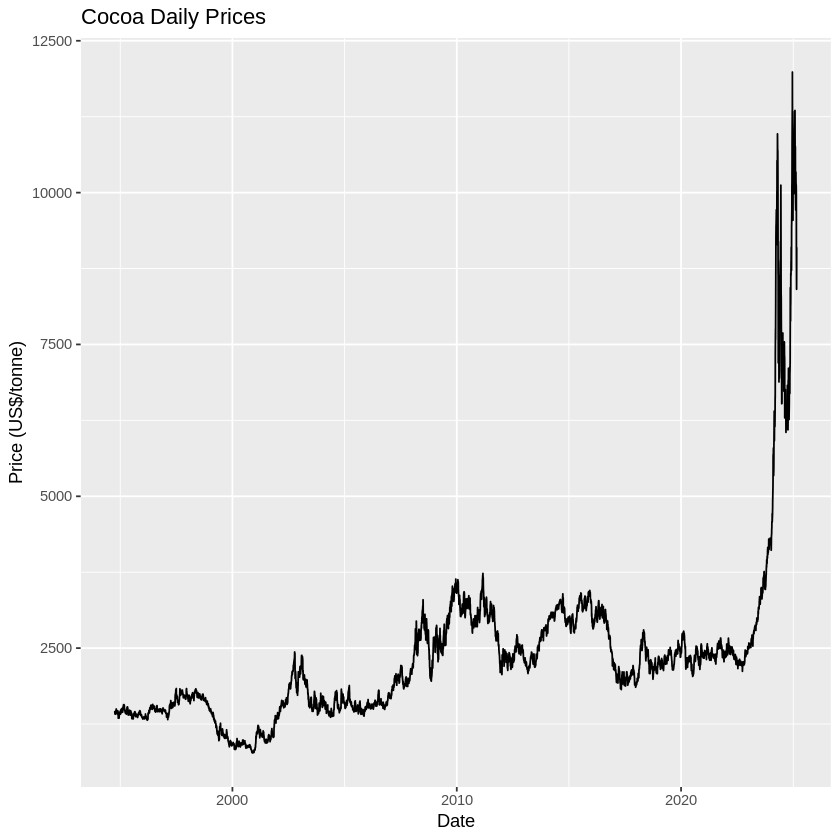

In [10]:
# Plot the time series
ggplot(cocoa_prices, aes(x=Date)) +
  geom_line(aes(y=prices)) +
  labs(title = "Cocoa Daily Prices", x = "Date", y = "Price (US$/tonne)")

In [11]:
# Function for converting the daily data to monthly data
turn_to_monthly = function(df) {
  monthly_prices = df %>%
                      mutate(Date = floor_date(Date, unit = "month")) %>%
                      group_by(Date) %>%
                      summarise(
                          max = max(prices),
                          avg = mean(prices),
                          min = min(prices)
                      )
  return(monthly_prices)
}

ACF,0.95,0.90,0.84,0.78,0.71,0.65,0.57,0.51,0.47,0.44,⋯,0.26,0.25,0.25,0.24,0.23,0.23,0.23,0.22,0.22,0.22
PACF,0.95,-0.04,-0.16,-0.01,-0.14,0.08,-0.24,0.18,0.23,0.00,⋯,0.00,0.03,-0.04,0.00,-0.02,0.10,0.02,-0.04,0.04,0.00


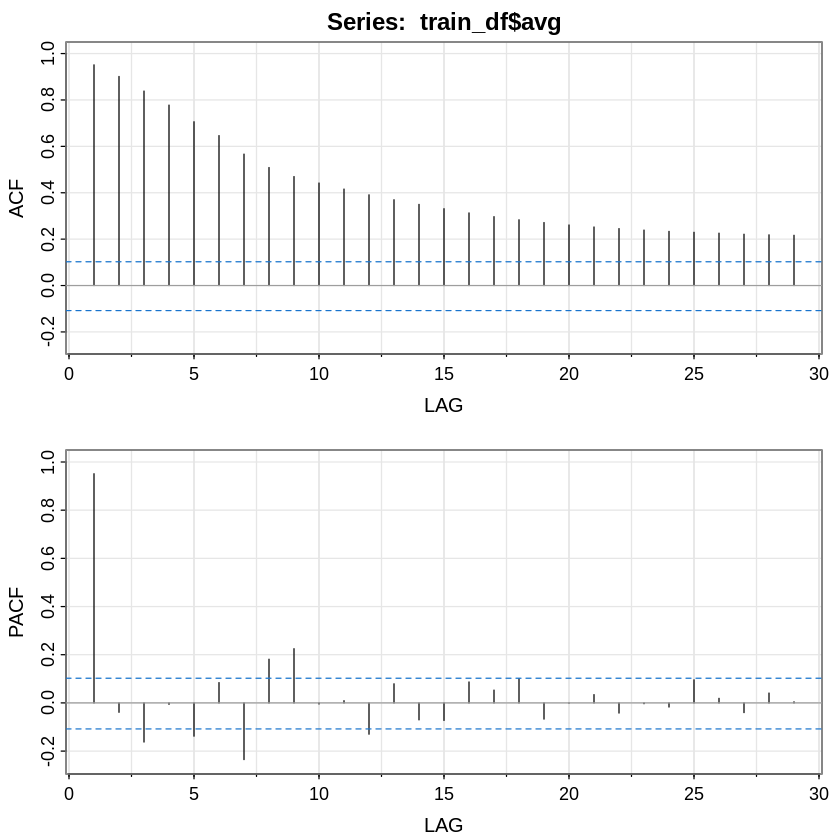

In [12]:
train_df = read.csv("train.csv")
train_df$Date = as.Date(train_df$Date, format = "%Y-%m-%d")

train_df = turn_to_monthly(train_df)
acf2(train_df$avg)

In [36]:
train_df = read.csv("train.csv")
train_df$Date = as.Date(train_df$Date, format = "%Y-%m-%d")
train_df = turn_to_monthly(train_df)

# Selection after shock
idx = which(train_df$Date >= "2024-01-01")
train_df = train_df[idx, ]

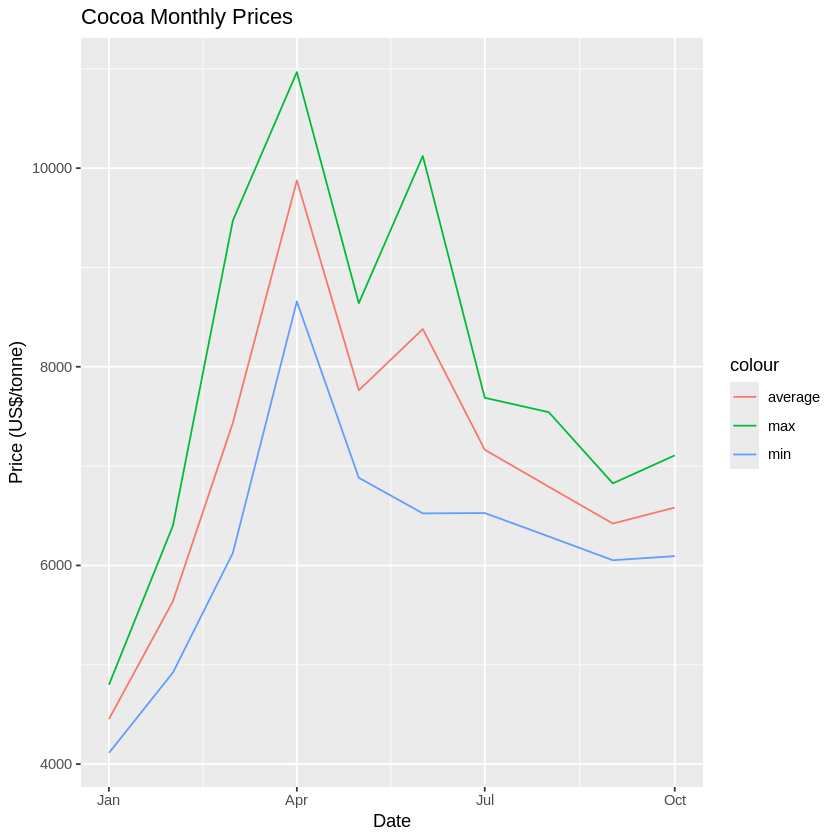

In [37]:
# Plot monthly prices
ggplot(train_df, aes(x=Date)) +
  geom_line(aes(y=avg, color = "average")) +
  geom_line(aes(y=min, color = "min")) +
  geom_line(aes(y=max, color = "max")) +
  labs(title = "Cocoa Monthly Prices", x = "Date", y = "Price (US$/tonne)")

# **ETS Model**

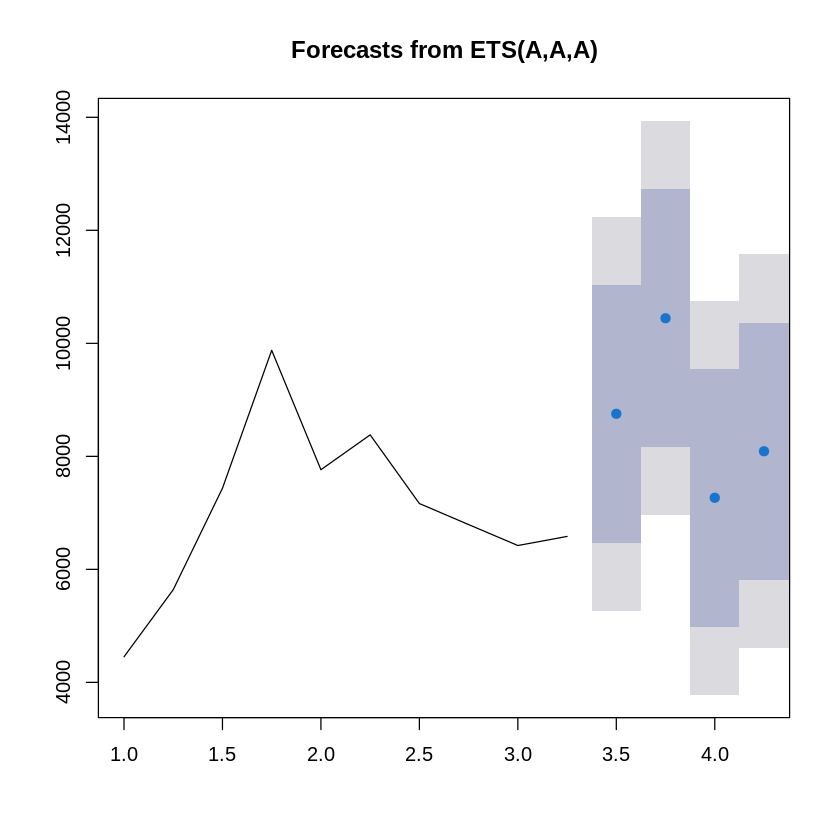

In [40]:
# ETS
prices_ts = ts(train_df$avg, frequency = 4)
# prices_ts = ts(tmp, frequency = 4)
ets_fit = ets(prices_ts, model = "AAA")
pred = predict(ets_fit, 4)
plot(pred)

In [41]:
summary(pred)


Forecast method: ETS(A,A,A)

Model Information:
ETS(A,A,A) 

Call:
ets(y = prices_ts, model = "AAA")

  Smoothing parameters:
    alpha = 0 
    beta  = 0 
    gamma = 0.2963 

  Initial states:
    l = 6851.1741 
    b = 168.4606 
    s = 3025.405 584.2519 -1211.086 -2398.571

  sigma:  1777.814
Error measures:
                    ME     RMSE      MAE       MPE     MAPE      MASE      ACF1
Training set -429.7291 1777.814 1299.227 -7.135178 17.98839 0.6213898 0.2174003

Forecasts:
     Point Forecast    Lo 80     Hi 80    Lo 95    Hi 95
3 Q3       8753.436 6475.076 11031.797 5268.985 12237.89
3 Q4      10444.209 8165.849 12722.569 6959.758 13928.66
4 Q1       7266.841 4988.481  9545.202 3782.390 10751.29
4 Q2       8089.858 5811.498 10368.218 4605.407 11574.31

In [17]:
# Find RMSE
test_df = read.csv("test.csv")
test_df$Date = as.Date(test_df$Date, format = "%Y-%m-%d")
test_df = turn_to_monthly(test_df)
rmse_ets = sqrt(mean((test_df$avg - pred$mean)^2))
rmse_ets

[1] 1972.019

# **SARIMA**

## **Preprocessing the data**

In [ ]:
install.packages("tsoutliers")
install.packages("strucchange")
install.packages("lubridate")
install.packages("dplyr")

library(strucchange)
library(ggplot2)
library(tsoutliers)
library(forecast)
library(tseries)
library(dplyr)
library(lubridate)
library(astsa)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘sandwich’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich



ACF,0.95,0.90,0.84,0.78,0.71,0.65,0.57,0.51,0.47,0.44,⋯,0.26,0.25,0.25,0.24,0.23,0.23,0.23,0.22,0.22,0.22
PACF,0.95,-0.04,-0.16,-0.01,-0.14,0.08,-0.24,0.18,0.23,0.00,⋯,0.00,0.03,-0.04,0.00,-0.02,0.10,0.02,-0.04,0.04,0.00


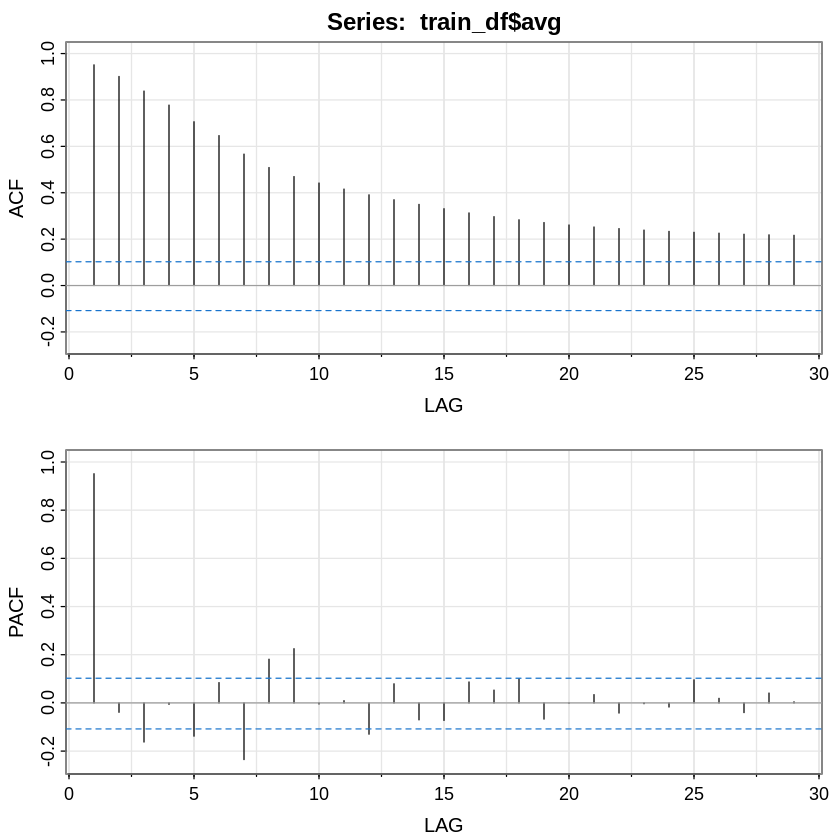

In [ ]:
train_df = read.csv("train.csv")
train_df$Date =as.Date(train_df$Date, format = "%Y-%m-%d")
train_df = turn_to_monthly(train_df)
acf2(train_df$avg)

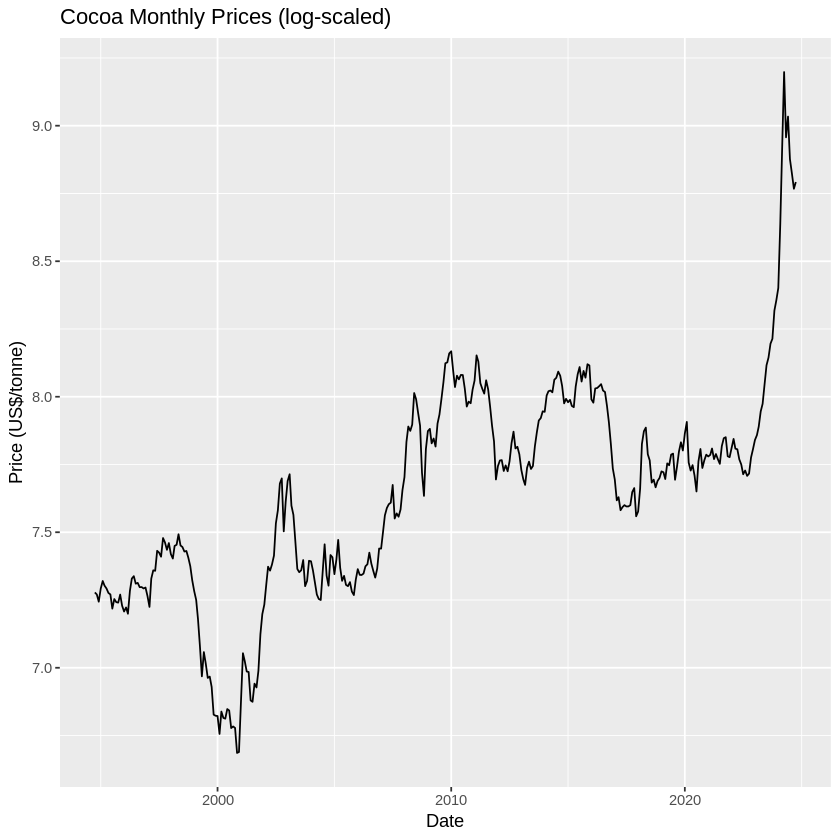

In [ ]:
# Variance stabilizing by taking log
train_df$log_price = log(train_df$avg)
ggplot(train_df, aes(x=Date)) +
  geom_line(aes(y=log_price)) +
  labs(title = "Cocoa Monthly Prices (log-scaled)", x = "Date", y = "Price (US$/tonne)")

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


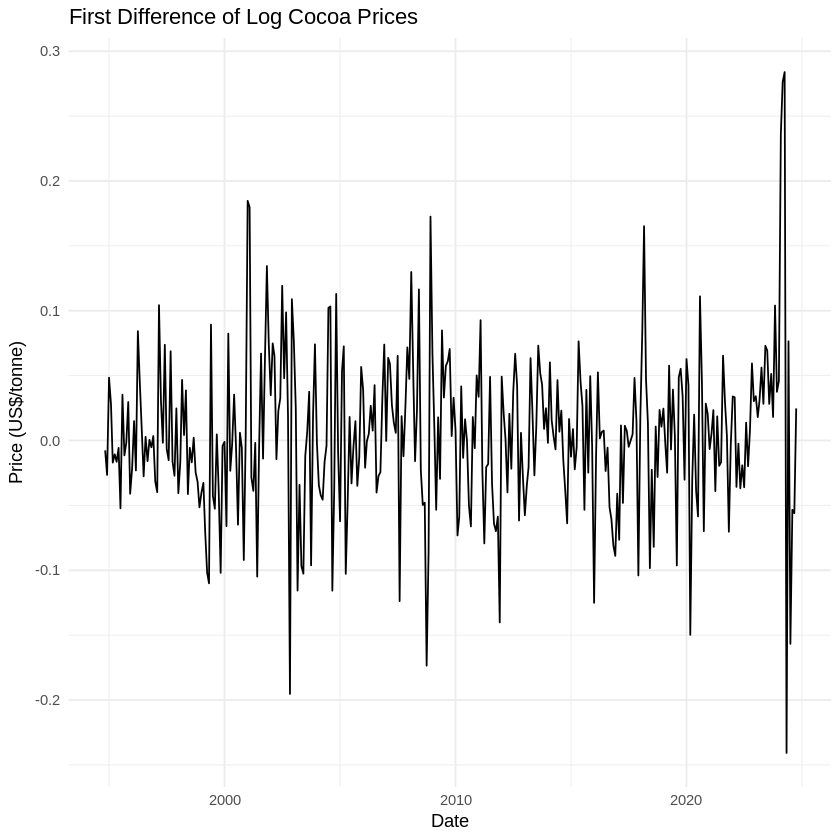

In [ ]:
# Taking first-order difference
train_df$diff_log_price <- c(NA, diff(train_df$log_price))
ggplot(train_df, aes(x = Date, y = diff_log_price)) +
  geom_line() +
  labs(title = "First Difference of Log Cocoa Prices",
       x = "Date",
       y = "Price (US$/tonne)") +
  theme_minimal()

ACF,0.2,0.01,0.03,0.03,-0.11,0.05,0.13,-0.05,-0.01,0.05,⋯,-0.06,0.03,0.10,-0.11,-0.11,0.09,-0.02,-0.08,0.04,0.11
PACF,0.2,-0.04,0.03,0.02,-0.12,0.10,0.10,-0.10,0.04,0.02,⋯,-0.07,0.03,0.09,-0.14,-0.05,0.10,-0.06,-0.02,0.00,0.07


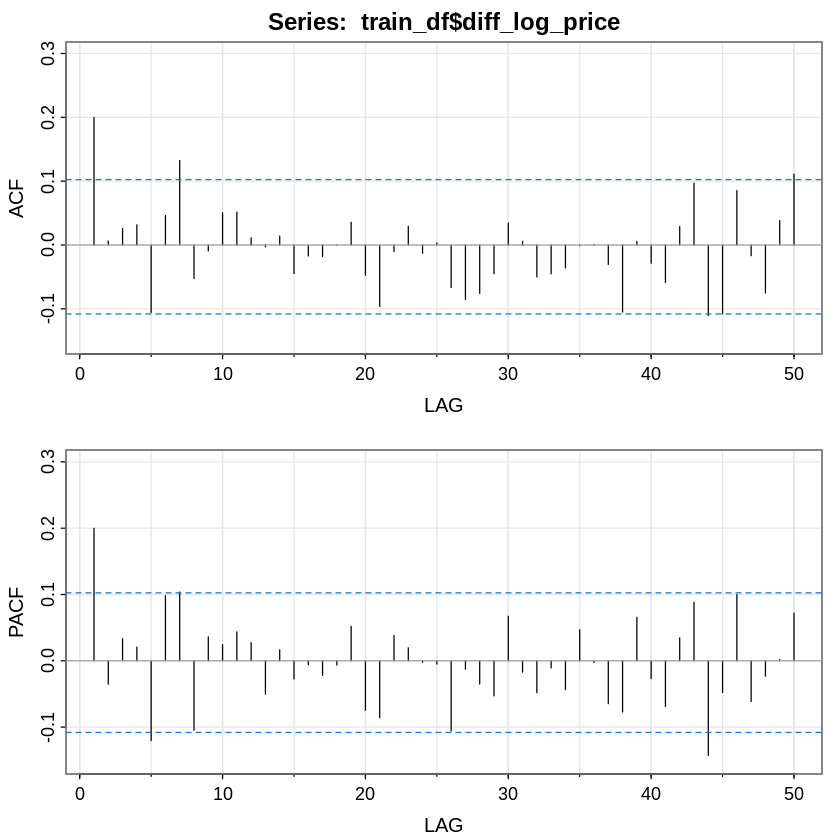

In [ ]:
# Plot ACF,PACF
acf2(train_df$diff_log_price,max.lag = 50, na.action = na.omit)

In [ ]:
# Can directly regard it as a stationary process
adf.test(na.omit(train_df$diff_log_price), alternative = "stationary")
# Augmented Dickey-Fuller (ADF) test support stationary

Warning message in adf.test(na.omit(train_df$diff_log_price), alternative = "stationary"):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  na.omit(train_df$diff_log_price)
Dickey-Fuller = -6.3855, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


In [ ]:
# Identify best ARIMA order (since diff_log_price is stationary, can do sarima for log_price)
sarima_model <- auto.arima(train_df$log_price,
                           seasonal = TRUE,
                           stepwise = FALSE,
                           approximation = FALSE)  # More accurate but slower
summary(sarima_model)
print(sarima_model)
# Result ARIMA(2,1,2) for log_price

Series: train_df$log_price 
ARIMA(2,1,2) 

Coefficients:
          ar1      ar2     ma1     ma2
      -1.1895  -0.6936  1.3805  0.8756
s.e.   0.0856   0.0781  0.0608  0.0557

sigma^2 = 0.003595:  log likelihood = 504.01
AIC=-998.01   AICc=-997.85   BIC=-978.58

Training set error measures:
                      ME       RMSE        MAE        MPE      MAPE      MASE
Training set 0.003673834 0.05954375 0.04300774 0.04341772 0.5600771 0.9626299
                   ACF1
Training set 0.04548133

Series: train_df$log_price 
ARIMA(2,1,2) 

Coefficients:
          ar1      ar2     ma1     ma2
      -1.1895  -0.6936  1.3805  0.8756
s.e.   0.0856   0.0781  0.0608  0.0557

sigma^2 = 0.003595:  log likelihood = 504.01
AIC=-998.01   AICc=-997.85   BIC=-978.58


## **Model Diagnostics**

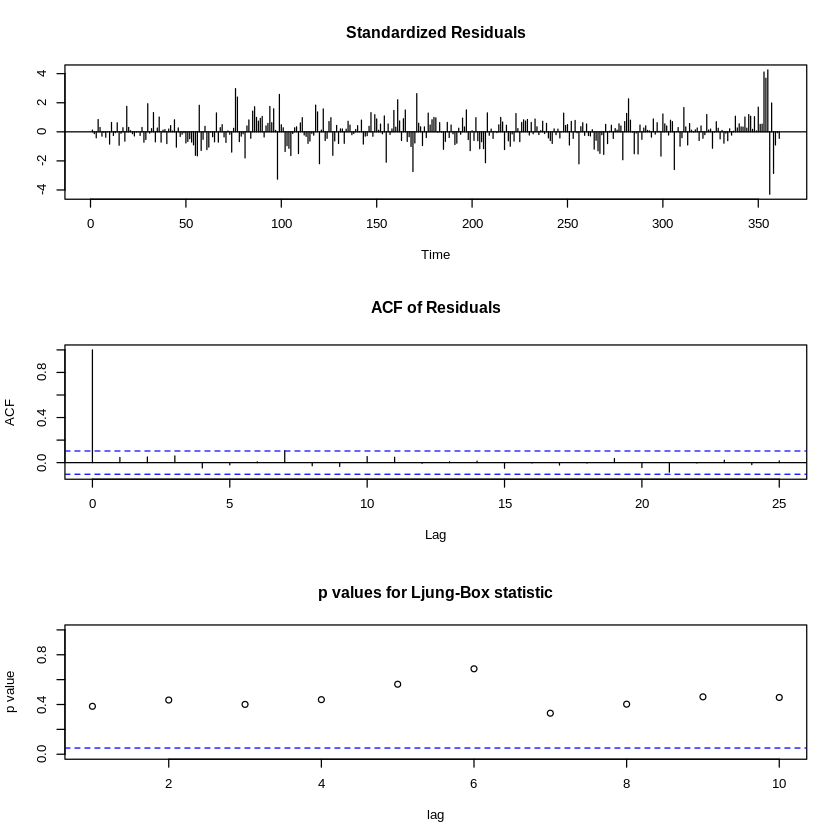

In [ ]:
# Diagnostic plots
tsdiag(sarima_model) # seems all are good

In [ ]:
# LJ test
Box.test(residuals(sarima_model), lag = 20, type = "Ljung-Box") # good (large p-value)


	Box-Ljung test

data:  residuals(sarima_model)
X-squared = 13.131, df = 20, p-value = 0.8717


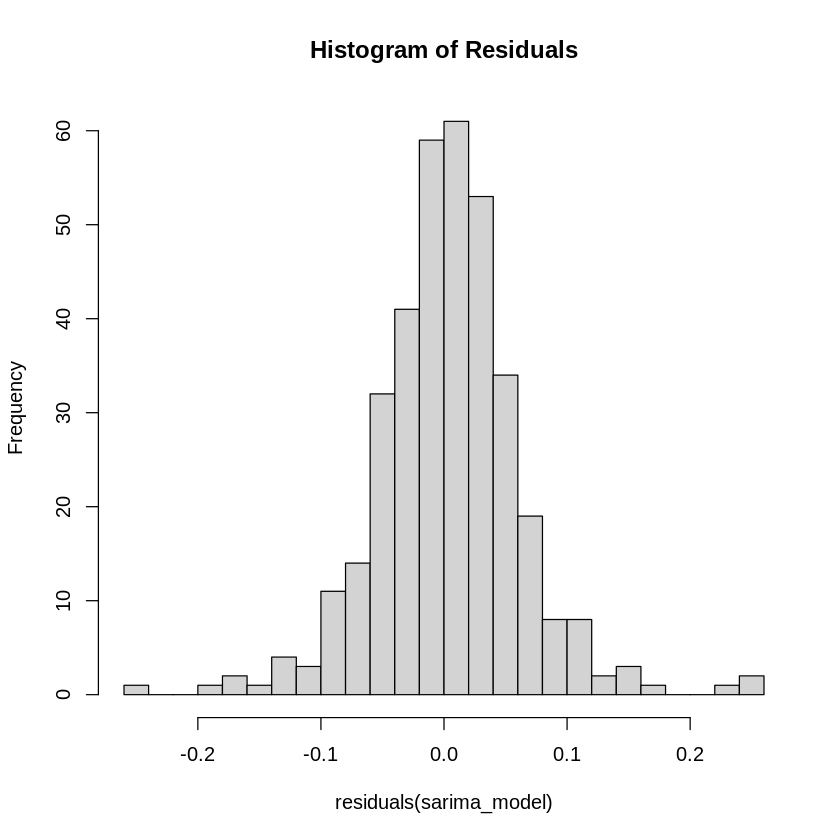

In [ ]:
# Histogram
hist(residuals(sarima_model), breaks = 30, main = "Histogram of Residuals") # except outliers, basically normality

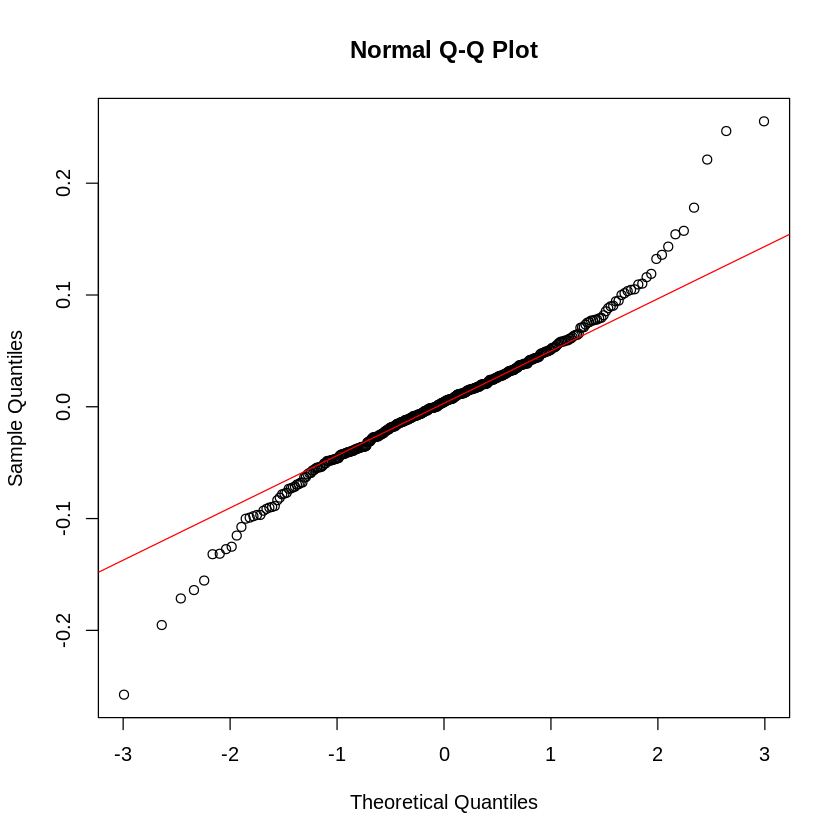

In [ ]:
# QQ plot
qqnorm(residuals(sarima_model))
qqline(residuals(sarima_model), col = "red") # may be not good here

## **Model Forecasting**

In [ ]:
# Forecasting the next 12 months in log scale
forecasted_log_prices <- forecast(sarima_model, h = 4)
forecasted_log_prices

    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
362       8.761595 8.684752 8.838437 8.644074 8.879115
363       8.757275 8.637771 8.876780 8.574509 8.940041
364       8.783657 8.635219 8.932095 8.556641 9.010674
365       8.755273 8.585692 8.924854 8.495921 9.014625

In [ ]:
# Back-transform to original price scale
forecasted_prices <- exp(forecasted_log_prices$mean)
forecasted_prices

A Time Series:
[1] 6384.284 6356.767 6526.702 6344.052

In [ ]:
# Combine the forecasted prices and original data
forecast_df <- data.frame(
  Date = seq(from = tail(train_df$Date, 1), by = "month", length.out = 4),
  Forecasted_Price = forecasted_prices
)

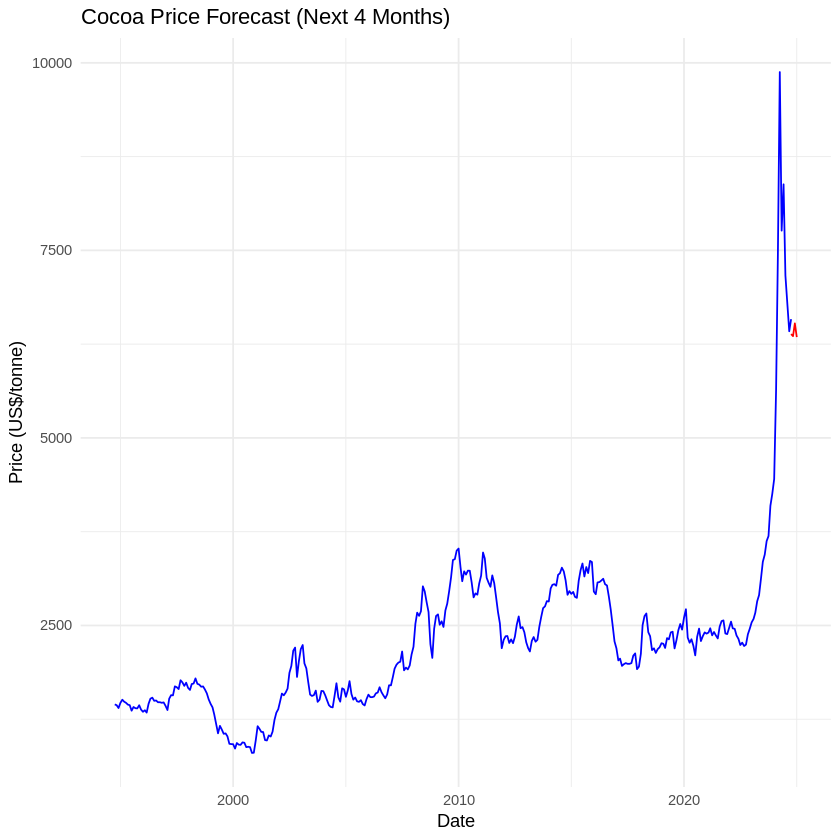

In [ ]:
ggplot() +
  geom_line(data = train_df, aes(x = Date, y = exp(log_price)), color = "blue") +  # Original price series
  geom_line(data = forecast_df, aes(x = Date, y = Forecasted_Price), color = "red") +  # Forecasted prices
  labs(title = "Cocoa Price Forecast (Next 4 Months)", x = "Date", y = "Price (US$/tonne)") +
  theme_minimal()

### **Prediction Evaluation**

In [ ]:
test_df = read.csv("test.csv")
test_df$Date = as.Date(test_df$Date, format = "%Y-%m-%d")
test_df = turn_to_monthly(test_df)

rmse_sarima = sqrt(mean((test_df$avg - forecasted_prices)^2))
rmse_sarima

[1] 3463.636

## **Chow Test**

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


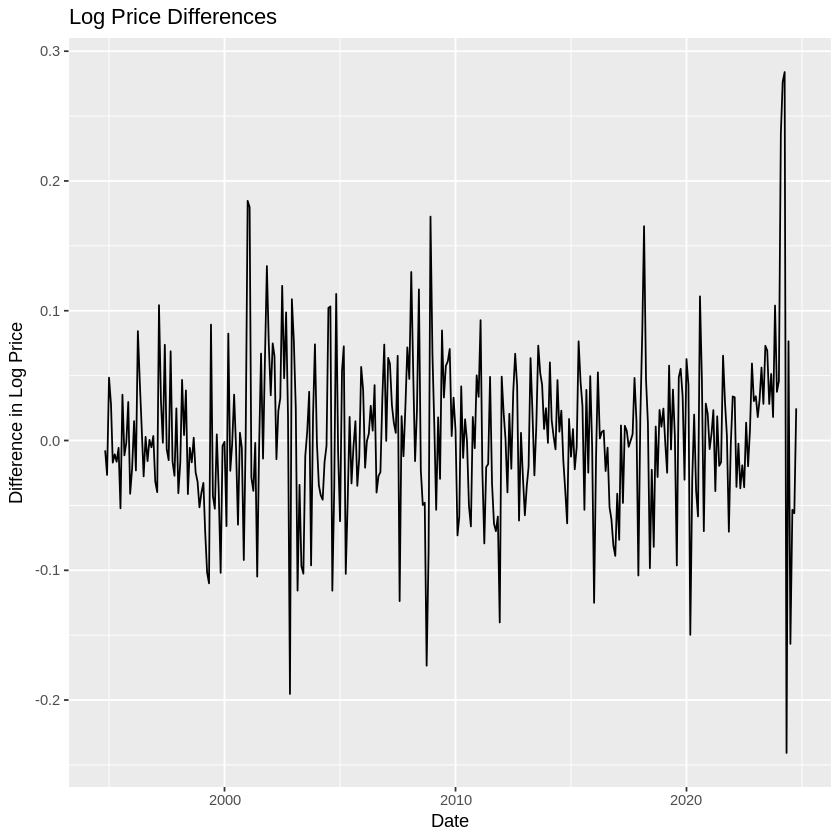

In [ ]:
# Find the break point
ggplot(train_df, aes(x = Date, y = diff_log_price)) +
  geom_line() +
  labs(title = "Log Price Differences", x = "Date", y = "Difference in Log Price")

In [ ]:
# Define a threshold for "large increase" in diff_log_price (e.g., > 0.2)
threshold <- 0.2
shock_periods <- which(train_df$diff_log_price > threshold)

# Print the shock periods (dates where the large increase occurs)
shock_dates <- train_df$Date[shock_periods]
shock_dates # See consecutive three months (Feb-Apr 2024) as large shock

[1] "2024-02-01" "2024-03-01" "2024-04-01"

In [ ]:
# Filter out shock periods where diff_log_price > 0.2
shock_data <- train_df[train_df$diff_log_price > threshold, ]

# Find the index of the maximum diff_log_price in the shock periods
max_shock_index <- which.max(shock_data$diff_log_price)

# Get the date corresponding to the largest shock
largest_shock_date <- shock_data$Date[max_shock_index]

# Print the largest shock date
print(largest_shock_date) # Largest one on Apr 2024

[1] "2024-04-01"


## **Chow test result**

In [ ]:
# Define the breakpoint date (March 2024)
break_date <- as.Date("2024-02-01")

# Split the dataset into pre- and post-break periods
pre_break_data <- train_df[train_df$Date < break_date, ]
post_break_data <- train_df[train_df$Date >= break_date, ]

# Fit a linear model on the entire data (or you can use ARIMA model if needed)
full_model <- lm(log_price ~ Date, data = train_df)

# Perform the Chow test using sctest
chow_test_result <- sctest(full_model, type = "Chow", point = break_date)

# Print the result of the Chow test
print(chow_test_result)
# Small p value infer that the there do exist structural change, need to split.


	M-fluctuation test

data:  full_model
f(efp) = 2.5519, p-value = 8.824e-06



## **Split and Modeling**

### **Before shock model**

In [ ]:
# Pre-break model (before February 2024)
pre_break_model <- auto.arima(pre_break_data$log_price, seasonal = TRUE)
summary(pre_break_model) # ARIMA(2,1,2)

Series: pre_break_data$log_price 
ARIMA(2,1,2) 

Coefficients:
          ar1      ar2     ma1     ma2
      -1.0926  -0.6704  1.3131  0.8132
s.e.   0.1420   0.1199  0.1123  0.1159

sigma^2 = 0.002834:  log likelihood = 533.28
AIC=-1056.55   AICc=-1056.38   BIC=-1037.25

Training set error measures:
                      ME       RMSE        MAE        MPE      MAPE      MASE
Training set 0.002839451 0.05285718 0.04003496 0.03417258 0.5281239 0.9573018
                   ACF1
Training set 0.02799659

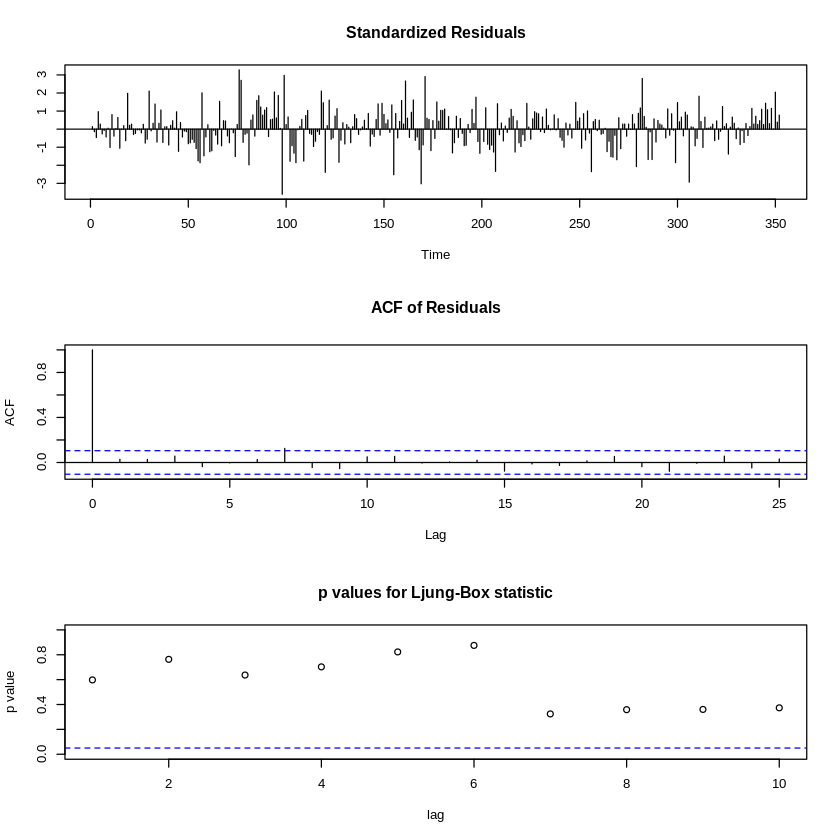

In [ ]:
# Diagnostic plots
tsdiag(pre_break_model) # seems all are good

In [ ]:
# LJ test
Box.test(residuals(pre_break_model), lag = 20, type = "Ljung-Box") # good (large p-value)


	Box-Ljung test

data:  residuals(pre_break_model)
X-squared = 16.17, df = 20, p-value = 0.706


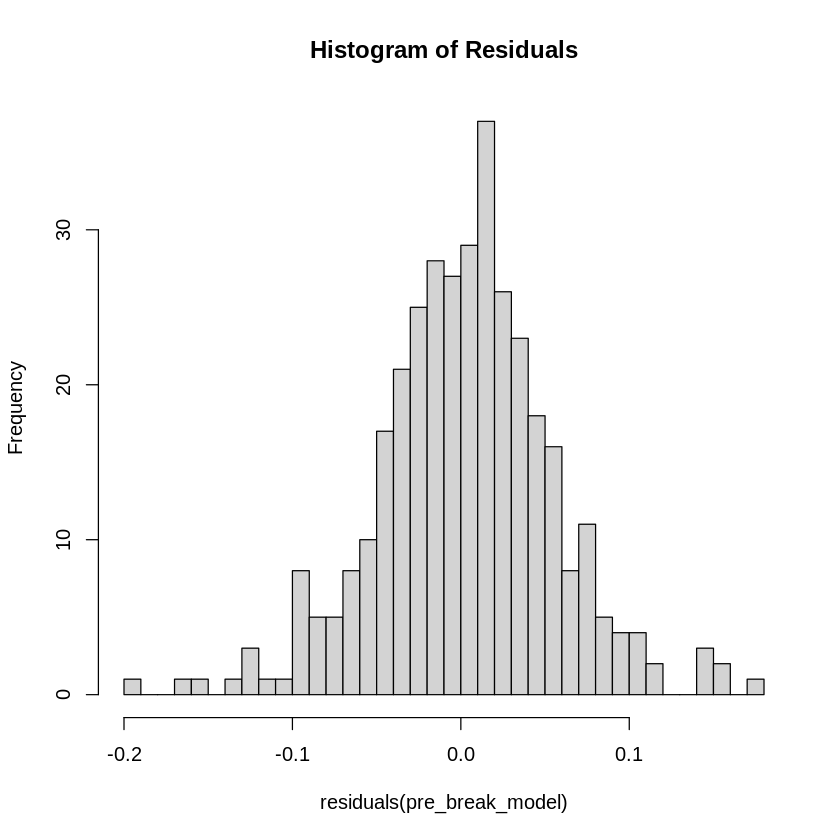

In [ ]:
# Histogram
hist(residuals(pre_break_model), breaks = 30, main = "Histogram of Residuals") # except outliers, basically normality

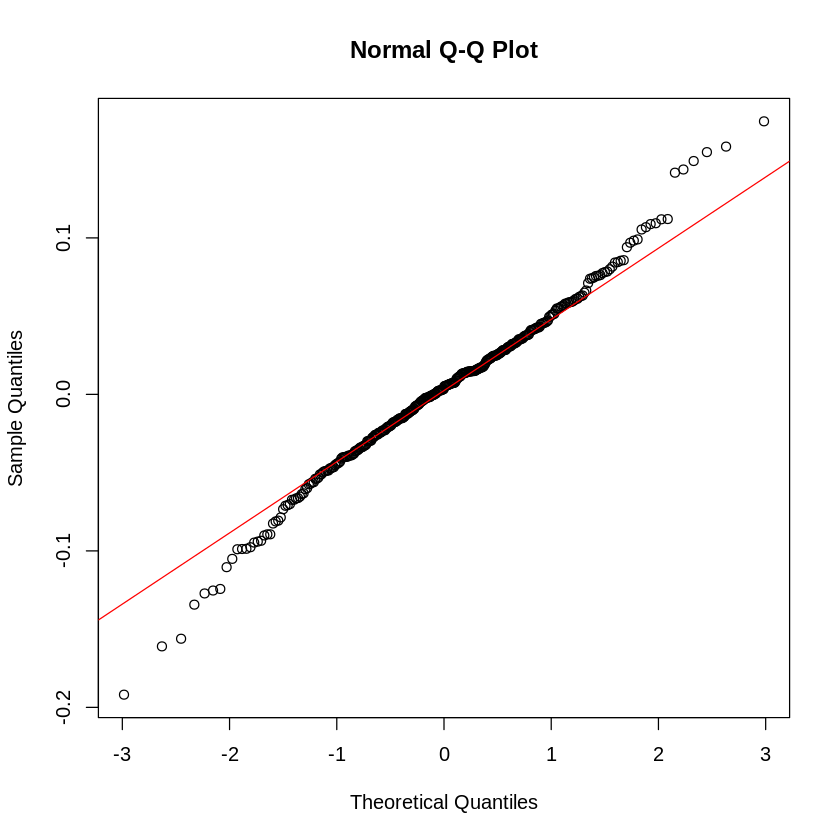

In [ ]:
# QQ plot
qqnorm(residuals(pre_break_model))
qqline(residuals(pre_break_model), col = "red") # better than the overallmodel

### **After shock model**

In [ ]:
# Post-break model (from February 2024 onward)
post_break_model <- auto.arima(post_break_data$log_price, seasonal = TRUE)
summary(post_break_model)

Series: post_break_data$log_price 
ARIMA(0,0,0) with non-zero mean 

Coefficients:
        mean
      8.8889
s.e.  0.0513

sigma^2 = 0.02667:  log likelihood = 4.07
AIC=-4.14   AICc=-2.14   BIC=-3.74

Training set error measures:
                       ME      RMSE       MAE         MPE     MAPE     MASE
Training set 2.763219e-15 0.1539731 0.1215469 -0.02980742 1.363985 0.832235
                  ACF1
Training set 0.2397114

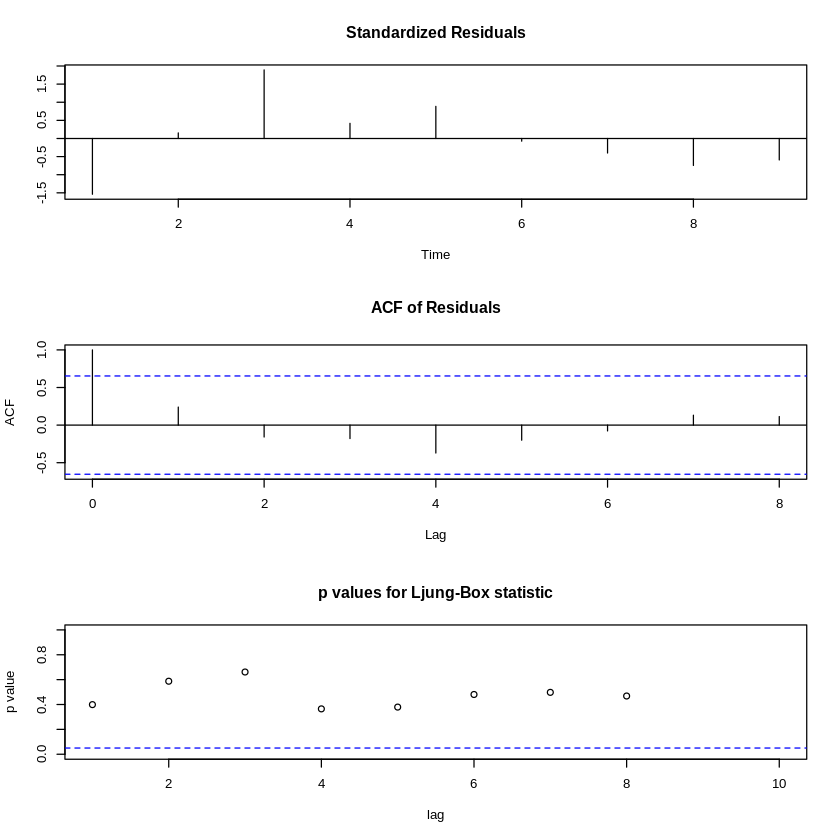

In [ ]:
# Diagnostic plots
tsdiag(post_break_model) # seems all are good

In [ ]:
# LJ test
Box.test(residuals(post_break_model), lag = 20, type = "Ljung-Box") # good (large p-value)


	Box-Ljung test

data:  residuals(post_break_model)
X-squared = NA, df = 20, p-value = NA


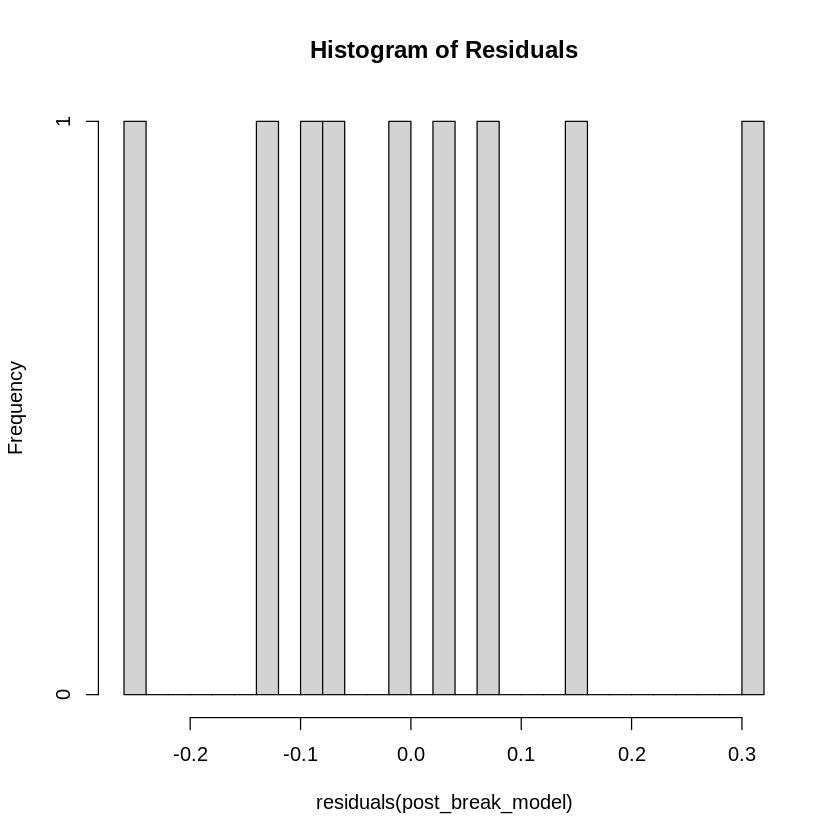

In [ ]:
# Histogram
hist(residuals(post_break_model), breaks = 30, main = "Histogram of Residuals") # except outliers, basically normality

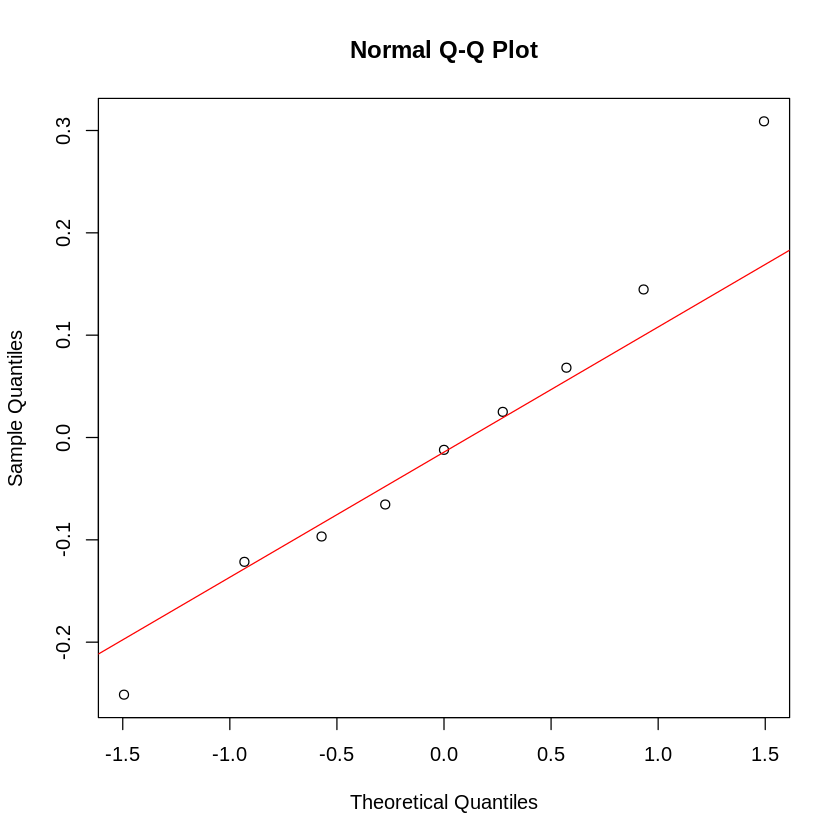

In [ ]:
# QQ plot
qqnorm(residuals(post_break_model))
qqline(residuals(post_break_model), col = "red") # better than the overallmodel

### **Converting to daily data**

In [ ]:
# Problem: Too little data point -> change back to daily data instead for after Apr 2024
train_df = read.csv("train.csv")
train_df$Date = as.Date(train_df$Date, format = "%Y-%m-%d")
idx = which(train_df$Date >= "2024-02-01")
train_df_after_shock_daily = train_df[idx, ]
# Reverse the data to go from oldest to newest
train_df_after_shock_daily <- train_df_after_shock_daily[order(train_df_after_shock_daily$Date), ]
head(train_df_after_shock_daily)

,Date,prices
,<date>,<dbl>
194,2024-02-01,4922.35
193,2024-02-02,4970.80
192,2024-02-05,5119.95
191,2024-02-06,5192.74
190,2024-02-07,5328.91
189,2024-02-08,5645.05


In [ ]:
# Log-transformation of the prices
train_df_after_shock_daily$log_price <- log(train_df_after_shock_daily$prices)

# Calculate the first-order difference of the log-prices
train_df_after_shock_daily$diff_log_price <- c(NA, diff(train_df_after_shock_daily$log_price))

# Check the new transformed data
head(train_df_after_shock_daily)

,Date,prices,log_price,diff_log_price
,<date>,<dbl>,<dbl>,<dbl>
194,2024-02-01,4922.35,8.501541,NA
193,2024-02-02,4970.80,8.511336,0.009794734
192,2024-02-05,5119.95,8.540900,0.029563880
191,2024-02-06,5192.74,8.555017,0.014116823
190,2024-02-07,5328.91,8.580902,0.025885218
189,2024-02-08,5645.05,8.638534,0.057632341


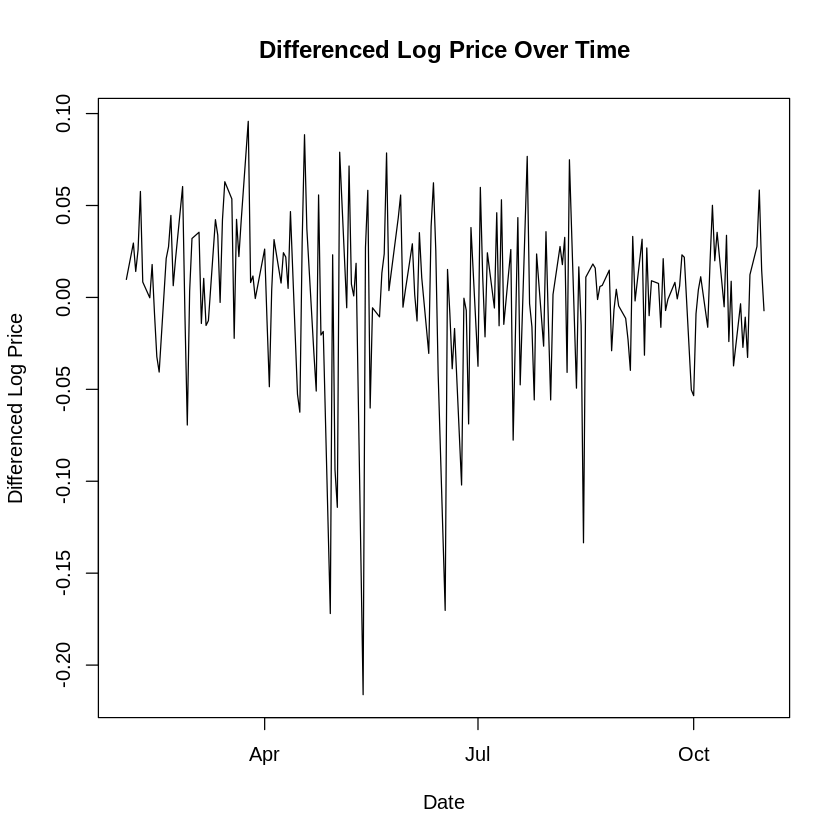

In [ ]:
# Plot the differenced log prices
plot(train_df_after_shock_daily$Date, train_df_after_shock_daily$diff_log_price, type = "l",
     xlab = "Date", ylab = "Differenced Log Price", main = "Differenced Log Price Over Time")

ACF,0,0.02,0.04,-0.05,0.13,-0.16,0.01,0.01,0.00,0.12,⋯,-0.04,-0.09,-0.09,-0.11,0.12,-0.06,-0.04,-0.06,0.09,0.07
PACF,0,0.02,0.04,-0.05,0.13,-0.17,0.01,0.00,0.02,0.08,⋯,-0.08,-0.05,-0.11,-0.11,0.13,-0.04,-0.04,-0.09,0.11,0.00


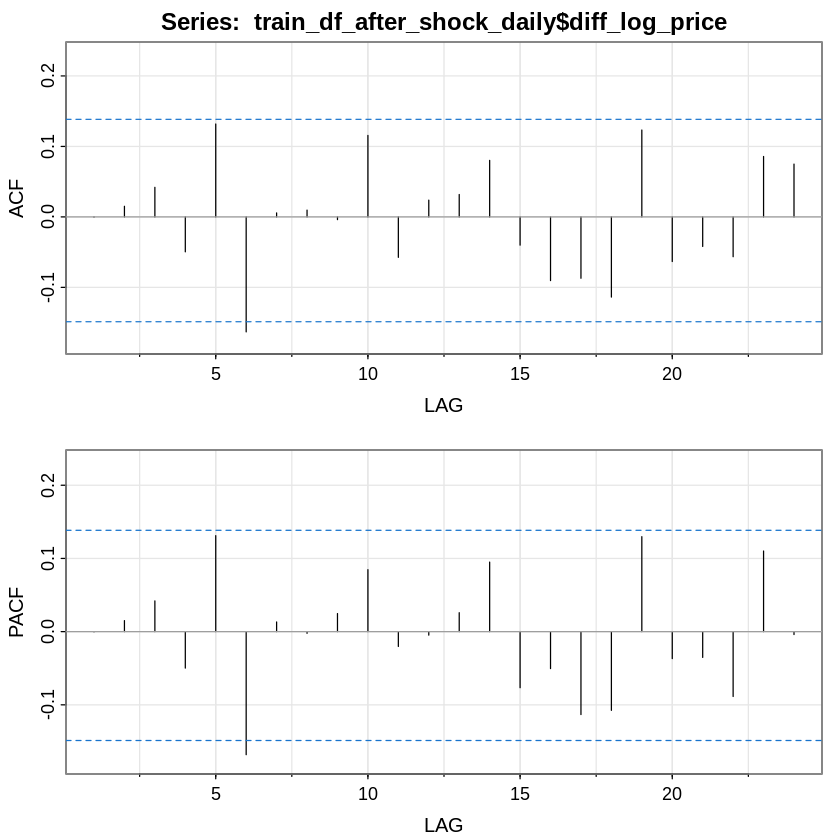

In [ ]:
acf2(train_df_after_shock_daily$diff_log_price)
# Can directly regard it as a stationary process

In [ ]:
adf.test(na.omit(train_df_after_shock_daily$diff_log_price), alternative = "stationary")
# Augmented Dickey-Fuller (ADF) test support stationary

Warning message in adf.test(na.omit(train_df_after_shock_daily$diff_log_price), :
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  na.omit(train_df_after_shock_daily$diff_log_price)
Dickey-Fuller = -5.9702, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


In [ ]:
sarima_model <- auto.arima(train_df_after_shock_daily$log_price,
                           seasonal = TRUE,
                           stepwise = FALSE,
                           approximation = FALSE)
summary(sarima_model)
print(sarima_model)

Series: train_df_after_shock_daily$log_price 
ARIMA(3,1,2) 

Coefficients:
          ar1      ar2      ar3     ma1     ma2
      -1.7674  -0.9306  -0.0102  1.8266  0.9477
s.e.   0.1050   0.1517   0.0908  0.0797  0.0541

sigma^2 = 0.00184:  log likelihood = 336.01
AIC=-660.03   AICc=-659.58   BIC=-640.45

Training set error measures:
                      ME       RMSE        MAE        MPE      MAPE      MASE
Training set 0.001795287 0.04222448 0.02990119 0.01961054 0.3356027 0.9663052
                     ACF1
Training set -0.000713238

Series: train_df_after_shock_daily$log_price 
ARIMA(3,1,2) 

Coefficients:
          ar1      ar2      ar3     ma1     ma2
      -1.7674  -0.9306  -0.0102  1.8266  0.9477
s.e.   0.1050   0.1517   0.0908  0.0797  0.0541

sigma^2 = 0.00184:  log likelihood = 336.01
AIC=-660.03   AICc=-659.58   BIC=-640.45


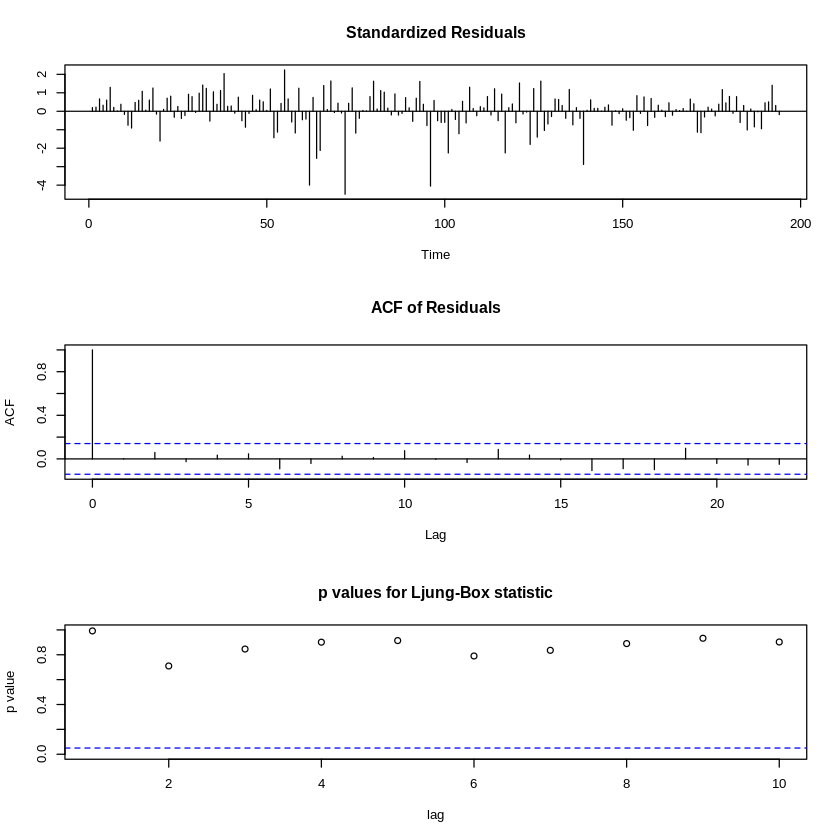

In [ ]:
# Diagnostic plots
tsdiag(sarima_model) # seems all are good

In [ ]:
# LJ test
Box.test(residuals(sarima_model), lag = 20, type = "Ljung-Box") # good (large p-value)


	Box-Ljung test

data:  residuals(sarima_model)
X-squared = 15.654, df = 20, p-value = 0.7378


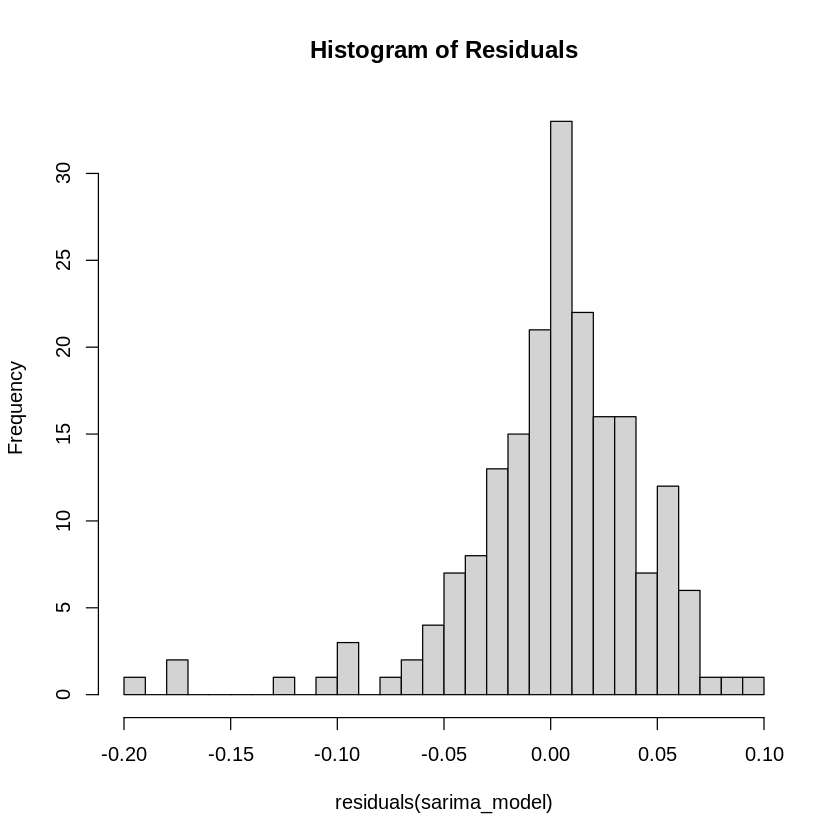

In [ ]:
# Histogram
hist(residuals(sarima_model), breaks = 30, main = "Histogram of Residuals") # except outliers, basically normality

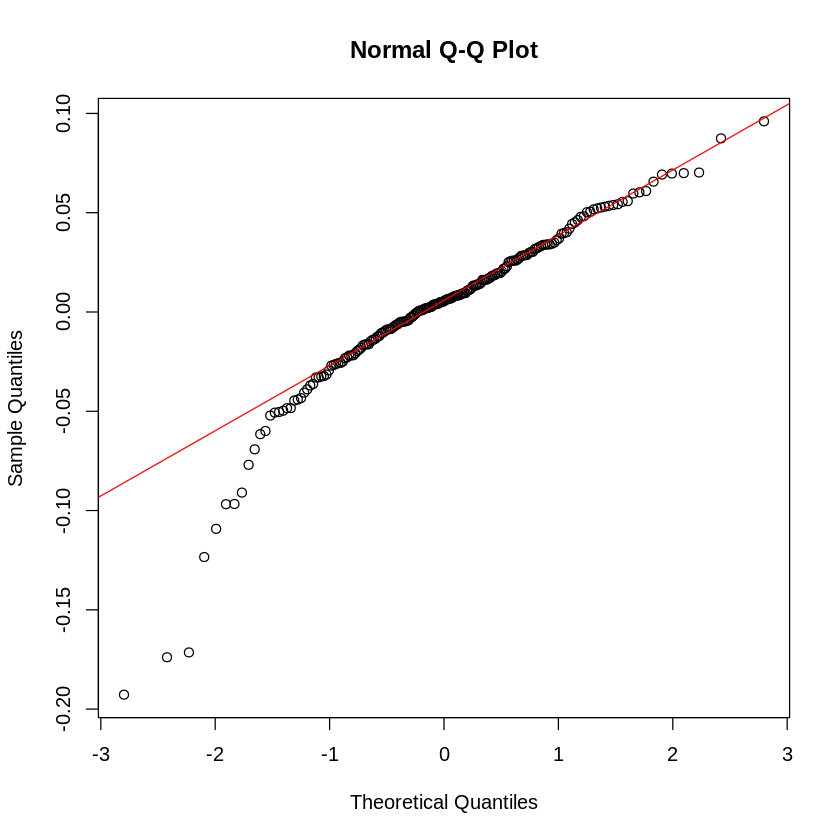

In [ ]:
# QQ plot
qqnorm(residuals(sarima_model))
qqline(residuals(sarima_model), col = "red") # may be not good here

## **Forecasting**

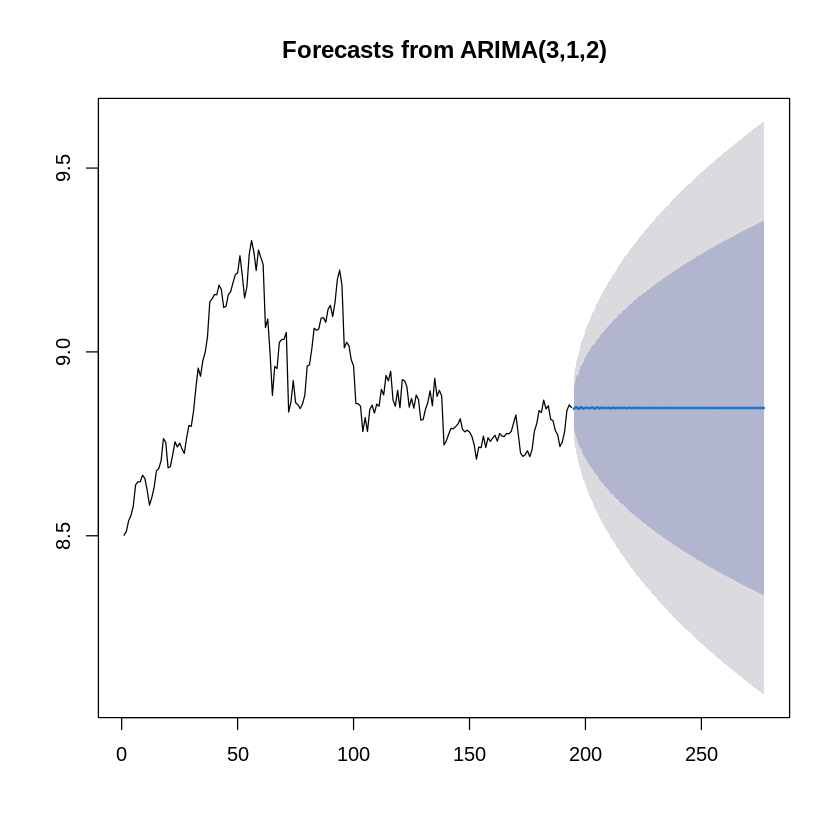

In [ ]:
# Forecasting the next 12 months in log scale
forecasted_log_prices <- forecast(sarima_model, h = 83)

# View the forecasted log prices
plot(forecasted_log_prices)

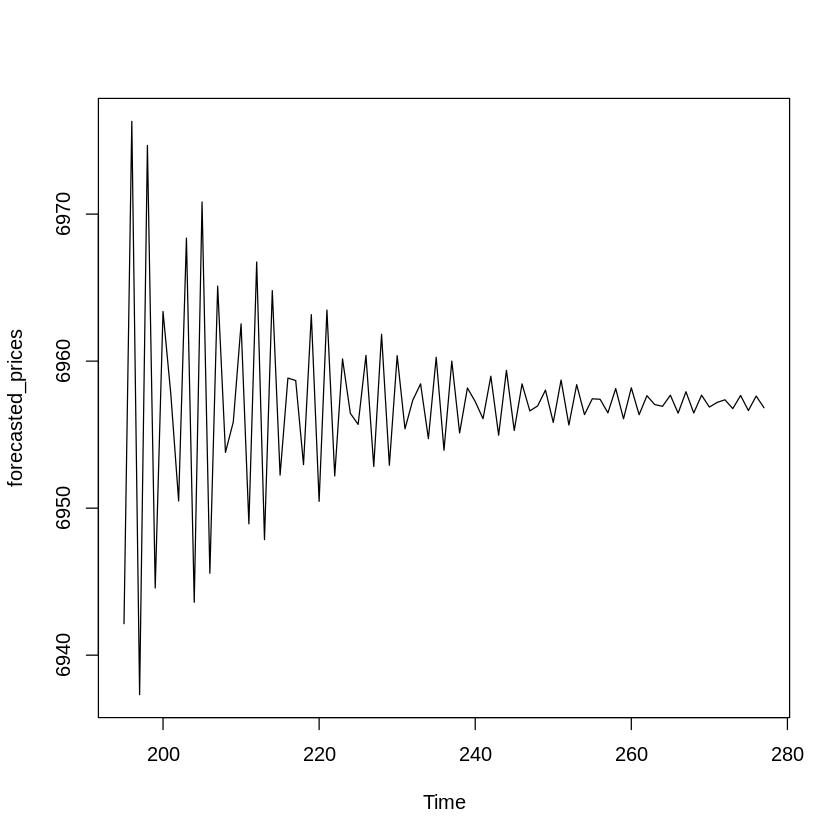

In [ ]:
# Back-transform to original price scale
forecasted_prices <- exp(forecasted_log_prices$mean)

# View the forecasted prices
plot(forecasted_prices)

In [ ]:
# Forecast dates (extend into 2025 based on the forecast length)
forecast_dates <- seq(from = tail(train_df_after_shock_daily$Date, 1),
                      by = "day", length.out = length(forecasted_prices))

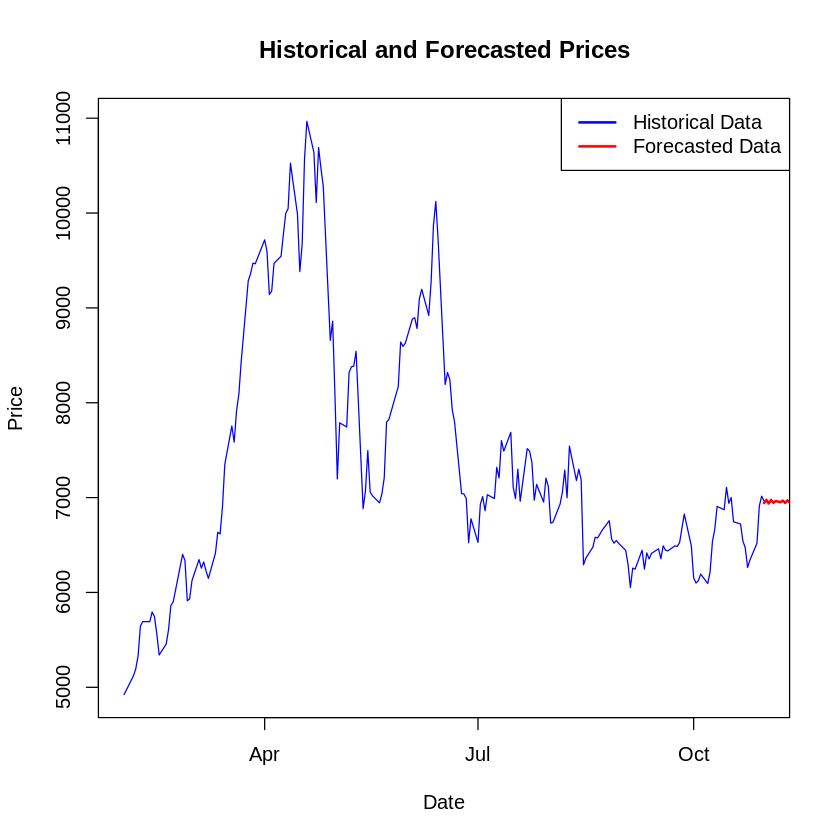

In [ ]:
# Historical data plot
plot(train_df_after_shock_daily$Date, train_df_after_shock_daily$prices, type = "l",
     col = "blue", xlab = "Date", ylab = "Price",
     main = "Historical and Forecasted Prices")
# Add forecasted data to the plot
lines(forecast_dates, forecasted_prices, col = "red", lwd = 2)
# Add legend
legend("topright", legend = c("Historical Data", "Forecasted Data"),
       col = c("blue", "red"), lty = c(1, 1), lwd = 2)

# **Spectral density + precipitation as exogeneous variable**

## **Clean precipitation data**

In [42]:
precip_transform = function(df) {
  precip = df %>%
            mutate(DATE = floor_date(DATE, unit = "month")) %>%
            group_by(DATE) %>%
            summarise(
                tavg = mean(TAVG, na.rm = TRUE),
                prcp = mean(PRCP, na.rm = TRUE)
            )
  return(precip)
}

[1] "Rows with NA value: 3"


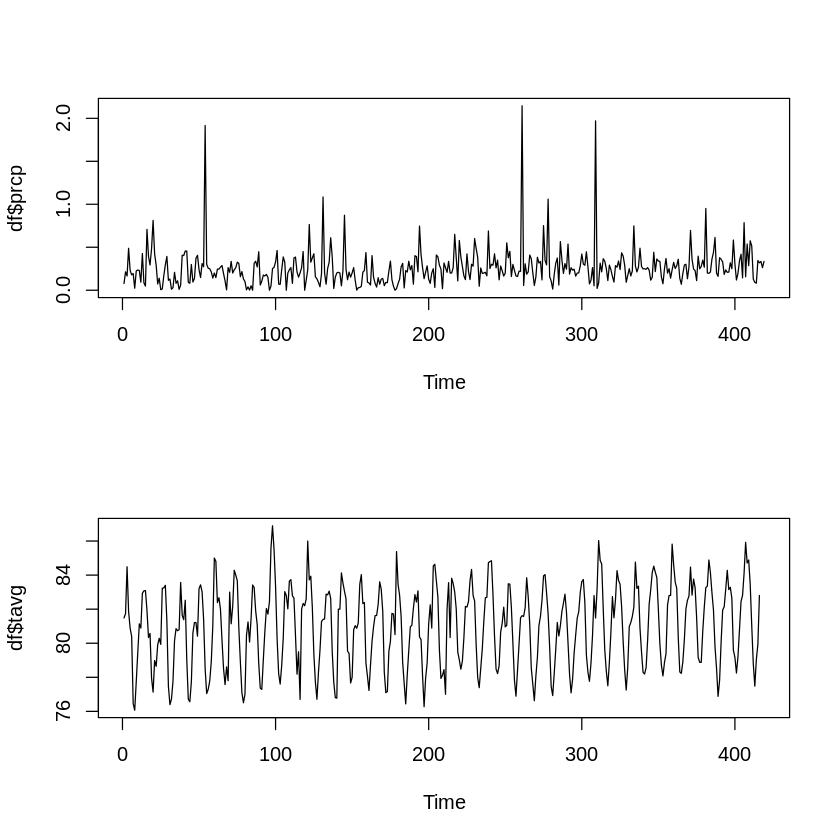

In [43]:
df = read.csv("Ghana_data.csv")
df$DATE = as.Date(df$DATE)
df = precip_transform(df)

# Add missing months
df[nrow(df)+1, ] = list(as.Date("1994-12-01"), NA, NA)
df[nrow(df)+1, ] = list(as.Date("2001-10-01"), NA, NA)
df[nrow(df)+1, ] = list(as.Date("2001-12-01"), NA, NA)

# Fill in missing data by replace them with average precipitation in that month across all years
tmp = df %>% separate(DATE, c("year", "month", "day")) %>%
      group_by(month) %>%
      summarise(
        prcp_month = mean(prcp, na.rm = TRUE)
      )

idx = which(is.na(df$prcp))
month_vec = separate(df[idx, ], col=DATE, into = c("year", "month", "day"))
df[idx, ]$prcp = lapply(month_vec, function(x) tmp$prcp_month[match(x, tmp$month)])$month
print(paste("Rows with NA value:", length(which(is.na(df)))))

par(mfrow = c(2, 1))
plot.ts(df$prcp)
plot.ts(df$tavg)

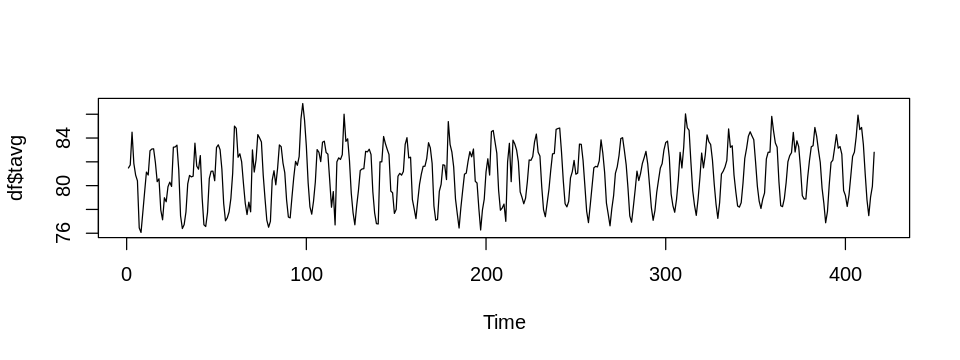

In [44]:
options(repr.plot.width=8, repr.plot.height=3)
plot.ts(df$tavg)
options(repr.plot.width=7, repr.plot.height=7)

In [45]:
train_df = read.csv("train.csv")
train_df$Date = as.Date(train_df$Date, format = "%Y-%m-%d")
train_df = turn_to_monthly(train_df)

# Match the time
tmp = df[which(df$DATE >= "1994-10-01" & df$DATE <= "2024-10-01"), ]

obs = ts(train_df$avg)
exo = ts(tmp$prcp)
c(length(obs), length(exo))

[1] 361 361

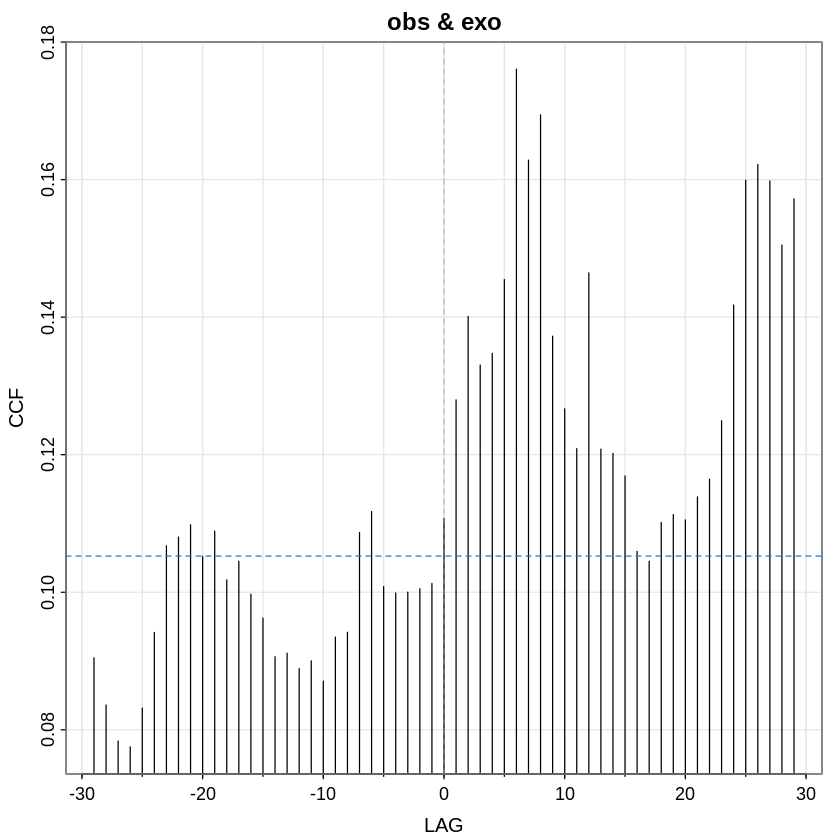

In [46]:
ccf = ccf2(obs, exo)
# lag 6 is the best

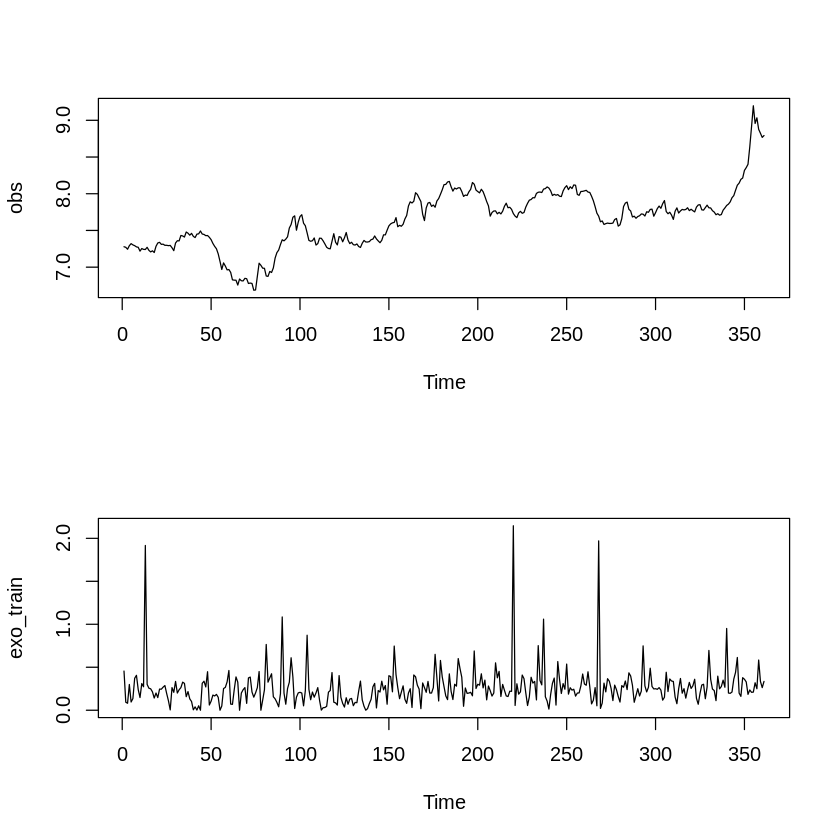

In [47]:
exo_train = df[which(df$DATE >= "1993-06-01" & df$DATE <= "2023-06-01"), ]
exo_train = ts(exo_train$prcp)
exo_test = df[which(df$DATE >= "2023-07-01" & df$DATE <= "2023-10-01"), ]
exo_test = ts(exo_test$prcp)
obs = log(obs)
par(mfrow = c(2, 1))
plot.ts(obs)
plot.ts(exo_train)

## **Modeling**

Bandwidth: 0.117 | Degrees of Freedom: 7.04 | split taper: 0% 


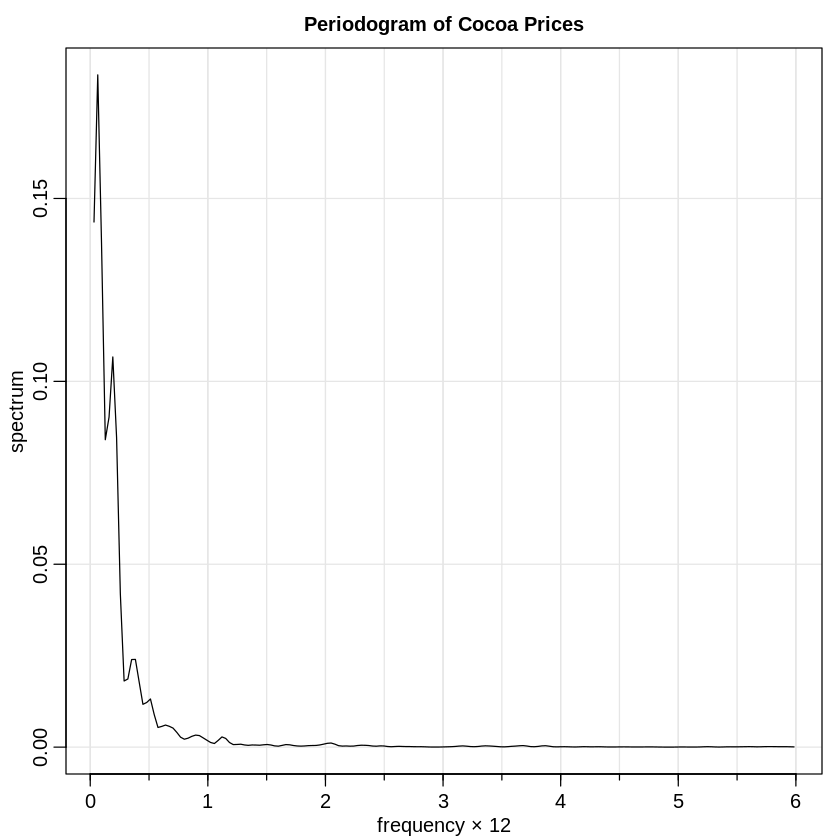

Dominant period:  15.625 months


Series: cocoa_ts 
Regression with ARIMA(2,1,2) errors 

Coefficients:
          ar1      ar2     ma1     ma2    S1-16   C1-16   S2-16    C2-16
      -1.1844  -0.6933  1.3751  0.8750  -0.0136  0.0078  0.0086  -0.0006
s.e.   0.0858   0.0779  0.0610  0.0546   0.0125  0.0125  0.0064   0.0064
      exo_train
        -0.0047
s.e.     0.0088

sigma^2 = 0.00361:  log likelihood = 505.8
AIC=-991.61   AICc=-990.98   BIC=-952.75

Training set error measures:
                      ME       RMSE        MAE        MPE      MAPE      MASE
Training set 0.003679073 0.05924777 0.04291073 0.04354265 0.5590893 0.2291647
                   ACF1
Training set 0.03981333

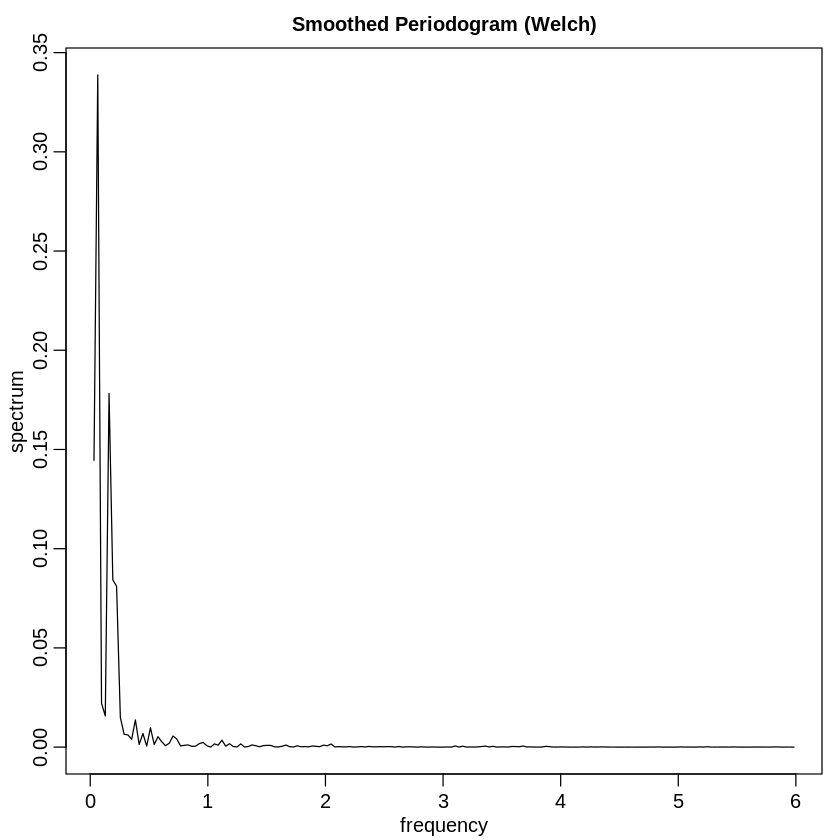

In [48]:
## Spectral Density
test_df = read.csv("test.csv")
test_df$Date = as.Date(test_df$Date, format = "%Y-%m-%d")
test_df = turn_to_monthly(test_df)

cocoa_ts = ts(train_df$avg, frequency = 12)
cocoa_ts = log(cocoa_ts)

# Compute and plot the Periodogram
spectrum = mvspec(cocoa_ts, spans = c(3, 3), log = "no", main = "Periodogram of Cocoa Prices")

# Apply Welch's method to smooth the Periodogram
w = spec.pgram(cocoa_ts, taper = 0.1, log = "no", main = "Smoothed Periodogram (Welch)")

# Identify the dominant frequency
main_freq = w$freq[which.max(w$spec)]
period = 1 / main_freq  # Compute the period in months
cat("Dominant period: ", period, "months\n")

#  Fit Fourier Model and ARIMA
harmonics = fourier(ts(cocoa_ts, frequency = period), K = 2) # Use two trigonometric functions to model the future harmonics
future_harmonics = fourier((ts(test_df$avg, frequency = period)), K = 2)
exo_train = as.vector(exo_train)
harmonics = cbind(harmonics, exo_train)
future_harmonics = cbind(future_harmonics, exo_test)

fit = Arima(cocoa_ts, order = c(2,1,2), xreg = harmonics)
summary(fit)

In [49]:
pred = predict(fit, h = 4, newxreg = future_harmonics)
pred = exp(pred$pred)

rmse_ets = sqrt(mean((test_df$avg - pred)^2))
rmse_ets

[1] 3527.027